In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Embedding, Dropout, BatchNormalization,Conv1D,GlobalMaxPooling1D,SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [ ]:
def read_data():
  df = pd.read_csv('processed_data.csv')
  print(df.head())
  return df

def make_arrays(df):
  input_tweets = np.array(df['PlainText'])
  output = np.array(df['Annotation'])
  return input_tweets,output

In [ ]:
df = read_data()

                                           PlainText Annotation
0  not serve people doubtful citizenship illegal ...          U
1  sio delhi welcome delhi court decision dischar...          S
2  gandhi godse biggest propoganda movie ever see...          U
3  brother jail three year time several caa nrc a...          U
4  oci card holder allowed enter india oci caa nr...          N


In [ ]:
df.Annotation.value_counts()

N    568
S    182
U    132
Name: Annotation, dtype: int64

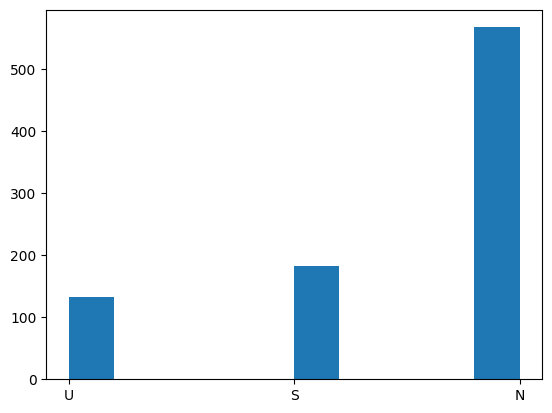

In [ ]:
plt.hist(df['Annotation'])
plt.show() 

In [ ]:
MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH = 100

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['PlainText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5378 unique tokens.


In [ ]:
tokenizer.word_index

{'caa': 1,
 'india': 2,
 'nrc': 3,
 'aatmanirbharbharat': 4,
 'muslim': 5,
 'people': 6,
 'scheme': 7,
 'samarth': 8,
 'country': 9,
 'policy': 10,
 'like': 11,
 'http': 12,
 'hindu': 13,
 'agnipath': 14,
 'one': 15,
 'indian': 16,
 'also': 17,
 'would': 18,
 'citizenship': 19,
 'bjp': 20,
 'year': 21,
 'govt': 22,
 'army': 23,
 'u': 24,
 'com': 25,
 'pakistan': 26,
 'make': 27,
 'law': 28,
 'government': 29,
 'need': 30,
 'protest': 31,
 'narendramodi': 32,
 'r': 33,
 'get': 34,
 'much': 35,
 'say': 36,
 'modi': 37,
 'first': 38,
 'new': 39,
 'minority': 40,
 'time': 41,
 'want': 42,
 'think': 43,
 'post': 44,
 'state': 45,
 'persecution': 46,
 'many': 47,
 'even': 48,
 'right': 49,
 'assam': 50,
 'made': 51,
 'take': 52,
 'message': 53,
 'private': 54,
 'religious': 55,
 'navy': 56,
 'please': 57,
 'know': 58,
 'fact': 59,
 'towards': 60,
 'good': 61,
 'indiannavy': 62,
 'see': 63,
 'textile': 64,
 'immigrant': 65,
 'point': 66,
 'said': 67,
 'support': 68,
 'add': 69,
 'vikrant': 70

In [ ]:
X = tokenizer.texts_to_sequences(df['PlainText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (882, 100)


In [ ]:
Y = pd.get_dummies(df['Annotation']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (882, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(793, 100) (793, 3)
(89, 100) (89, 3)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer = optimizer,loss = loss,metrics = [acc])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          200000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 280,703
Trainable params: 280,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer = optimizer,loss = loss,metrics = [acc])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.2, class_weight={0:1,1:2,2:2})
# , batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/50
20/20 [==============================] - 34s 1s/step - loss: 1.7788 - accuracy: 0.6167 - val_loss: 1.0597 - val_accuracy: 0.6164
Epoch 2/50
20/20 [==============================] - 13s 635ms/step - loss: 1.2545 - accuracy: 0.7303 - val_loss: 0.9506 - val_accuracy: 0.5912
Epoch 3/50
20/20 [==============================] - 12s 601ms/step - loss: 0.9346 - accuracy: 0.8344 - val_loss: 1.1066 - val_accuracy: 0.6289
Epoch 4/50
20/20 [==============================] - 12s 595ms/step - loss: 0.6084 - accuracy: 0.9227 - val_loss: 1.3421 - val_accuracy: 0.6289
Epoch 5/50
20/20 [==============================] - 12s 586ms/step - loss: 0.5183 - accuracy: 0.9479 - val_loss: 1.4586 - val_accuracy: 0.6101
Epoch 6/50
20/20 [==============================] - 12s 588ms/step - loss: 0.4022 - accuracy: 0.9700 - val_loss: 1.3388 - val_accuracy: 0.6541
Epoch 7/50
20/20 [==============================] - 11s 567ms/step - loss: 0.4276 - accuracy: 0.9716 - val_loss: 1.3044 - val_accuracy: 0.6352
Ep

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 32ms/step - loss: 1.7750 - accuracy: 0.5730
Test set
  Loss: 1.775
  Accuracy: 0.573


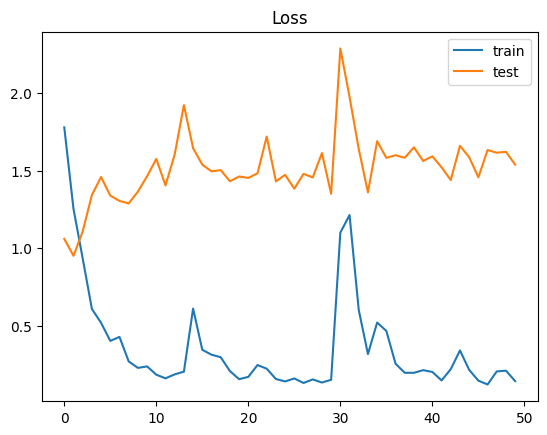

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

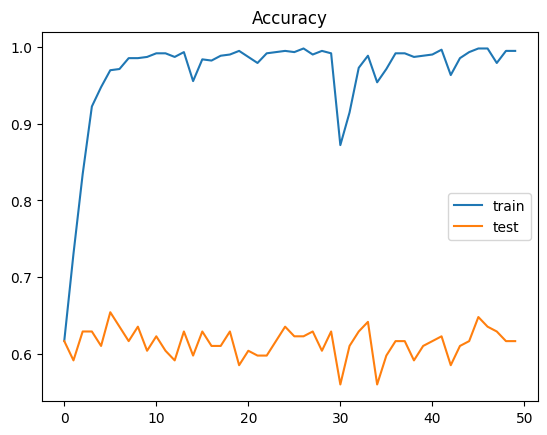

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
predictions = model.predict(X_test)
y_score = predictions

3/3 [==============================] - 0s 31ms/step


In [ ]:
y_pred = []

for x in predictions:
    y = np.argmax(x)
    y_pred.append(y)

predictions = y_pred

In [ ]:
y_pred = []

for x in Y_test:
    y = np.argmax(x)
    y_pred.append(y)

Y_test = y_pred

Accuracy_score:  0.5730337078651685
Precision_score:  0.39707341269841273
Recall_score:  0.3718275652701883
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        61
           1       0.24      0.28      0.26        18
           2       0.25      0.10      0.14        10

    accuracy                           0.57        89
   macro avg       0.40      0.37      0.37        89
weighted avg       0.56      0.57      0.56        89



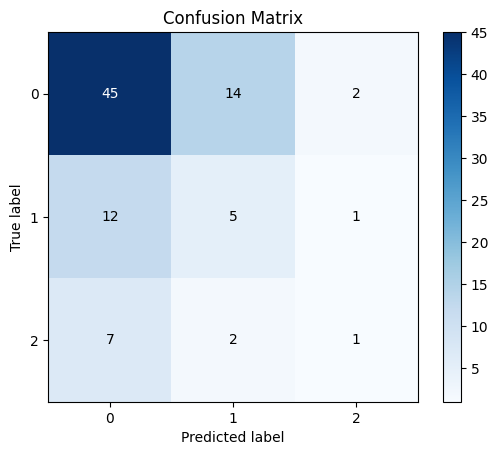

In [ ]:
plot_confusion_matrix(Y_test,predictions)
acc_score = accuracy_score(Y_test,predictions)
pre_score = precision_score(Y_test,predictions,average='macro')
rec_score = recall_score(Y_test,predictions,average='macro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(Y_test,predictions)
print(cr)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape 

(89, 3)

In [ ]:
label_binarizer.transform([1])

array([[0, 1, 0]])

In [ ]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.6107367  0.35243082 0.03683237]
 [0.20311221 0.7416302  0.05525761]]

y_score.ravel():
[0.6107367  0.35243082 0.03683237 0.20311221 0.7416302  0.05525761]


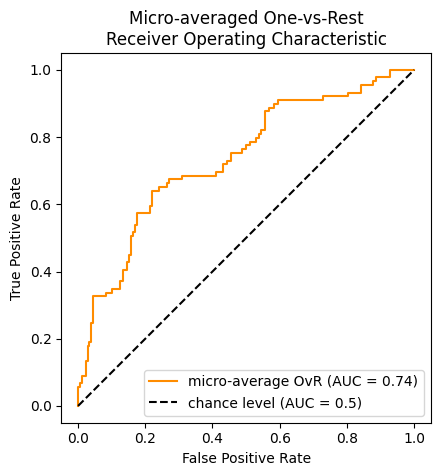

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()